# RideWise Customer Analytics
## Notebook 03: Feature Engineering & Churn Modeling (with RFMS)

### Purpose
This notebook trains churn prediction models using the churn-labeled + RFMS dataset created in Notebook 02.

We will:
- Load the processed dataset that includes churn label and RFMS features
- Prepare features (handle NaNs safely, encode categories, scale numeric variables)
- Split into train/test sets (without leakage)
- Train baseline and stronger models
- Evaluate models using churn-relevant metrics
- Interpret results for business action

Key rule: All missing values are handled inside preprocessing pipelines to prevent leakage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap
import joblib
from pathlib import Path

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv('../../data/processed_data/riders_trips_rfms_churned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              10000 non-null  object 
 1   recency              10000 non-null  int64  
 2   total_trips          10000 non-null  int64  
 3   total_spend          10000 non-null  float64
 4   avg_spend            10000 non-null  float64
 5   avg_surge            10000 non-null  float64
 6   total_tip            10000 non-null  float64
 7   avg_tip              10000 non-null  float64
 8   avg_rating_given     10000 non-null  float64
 9   loyalty_status       10000 non-null  object 
 10  city                 10000 non-null  object 
 11  avg_distance         10000 non-null  float64
 12  avg_duration         10000 non-null  float64
 13  active_days          10000 non-null  int64  
 14  RFMS_weighted_score  10000 non-null  float64
 15  RFMS_segment         10000 non-null  

#### Exploring the shape of the features

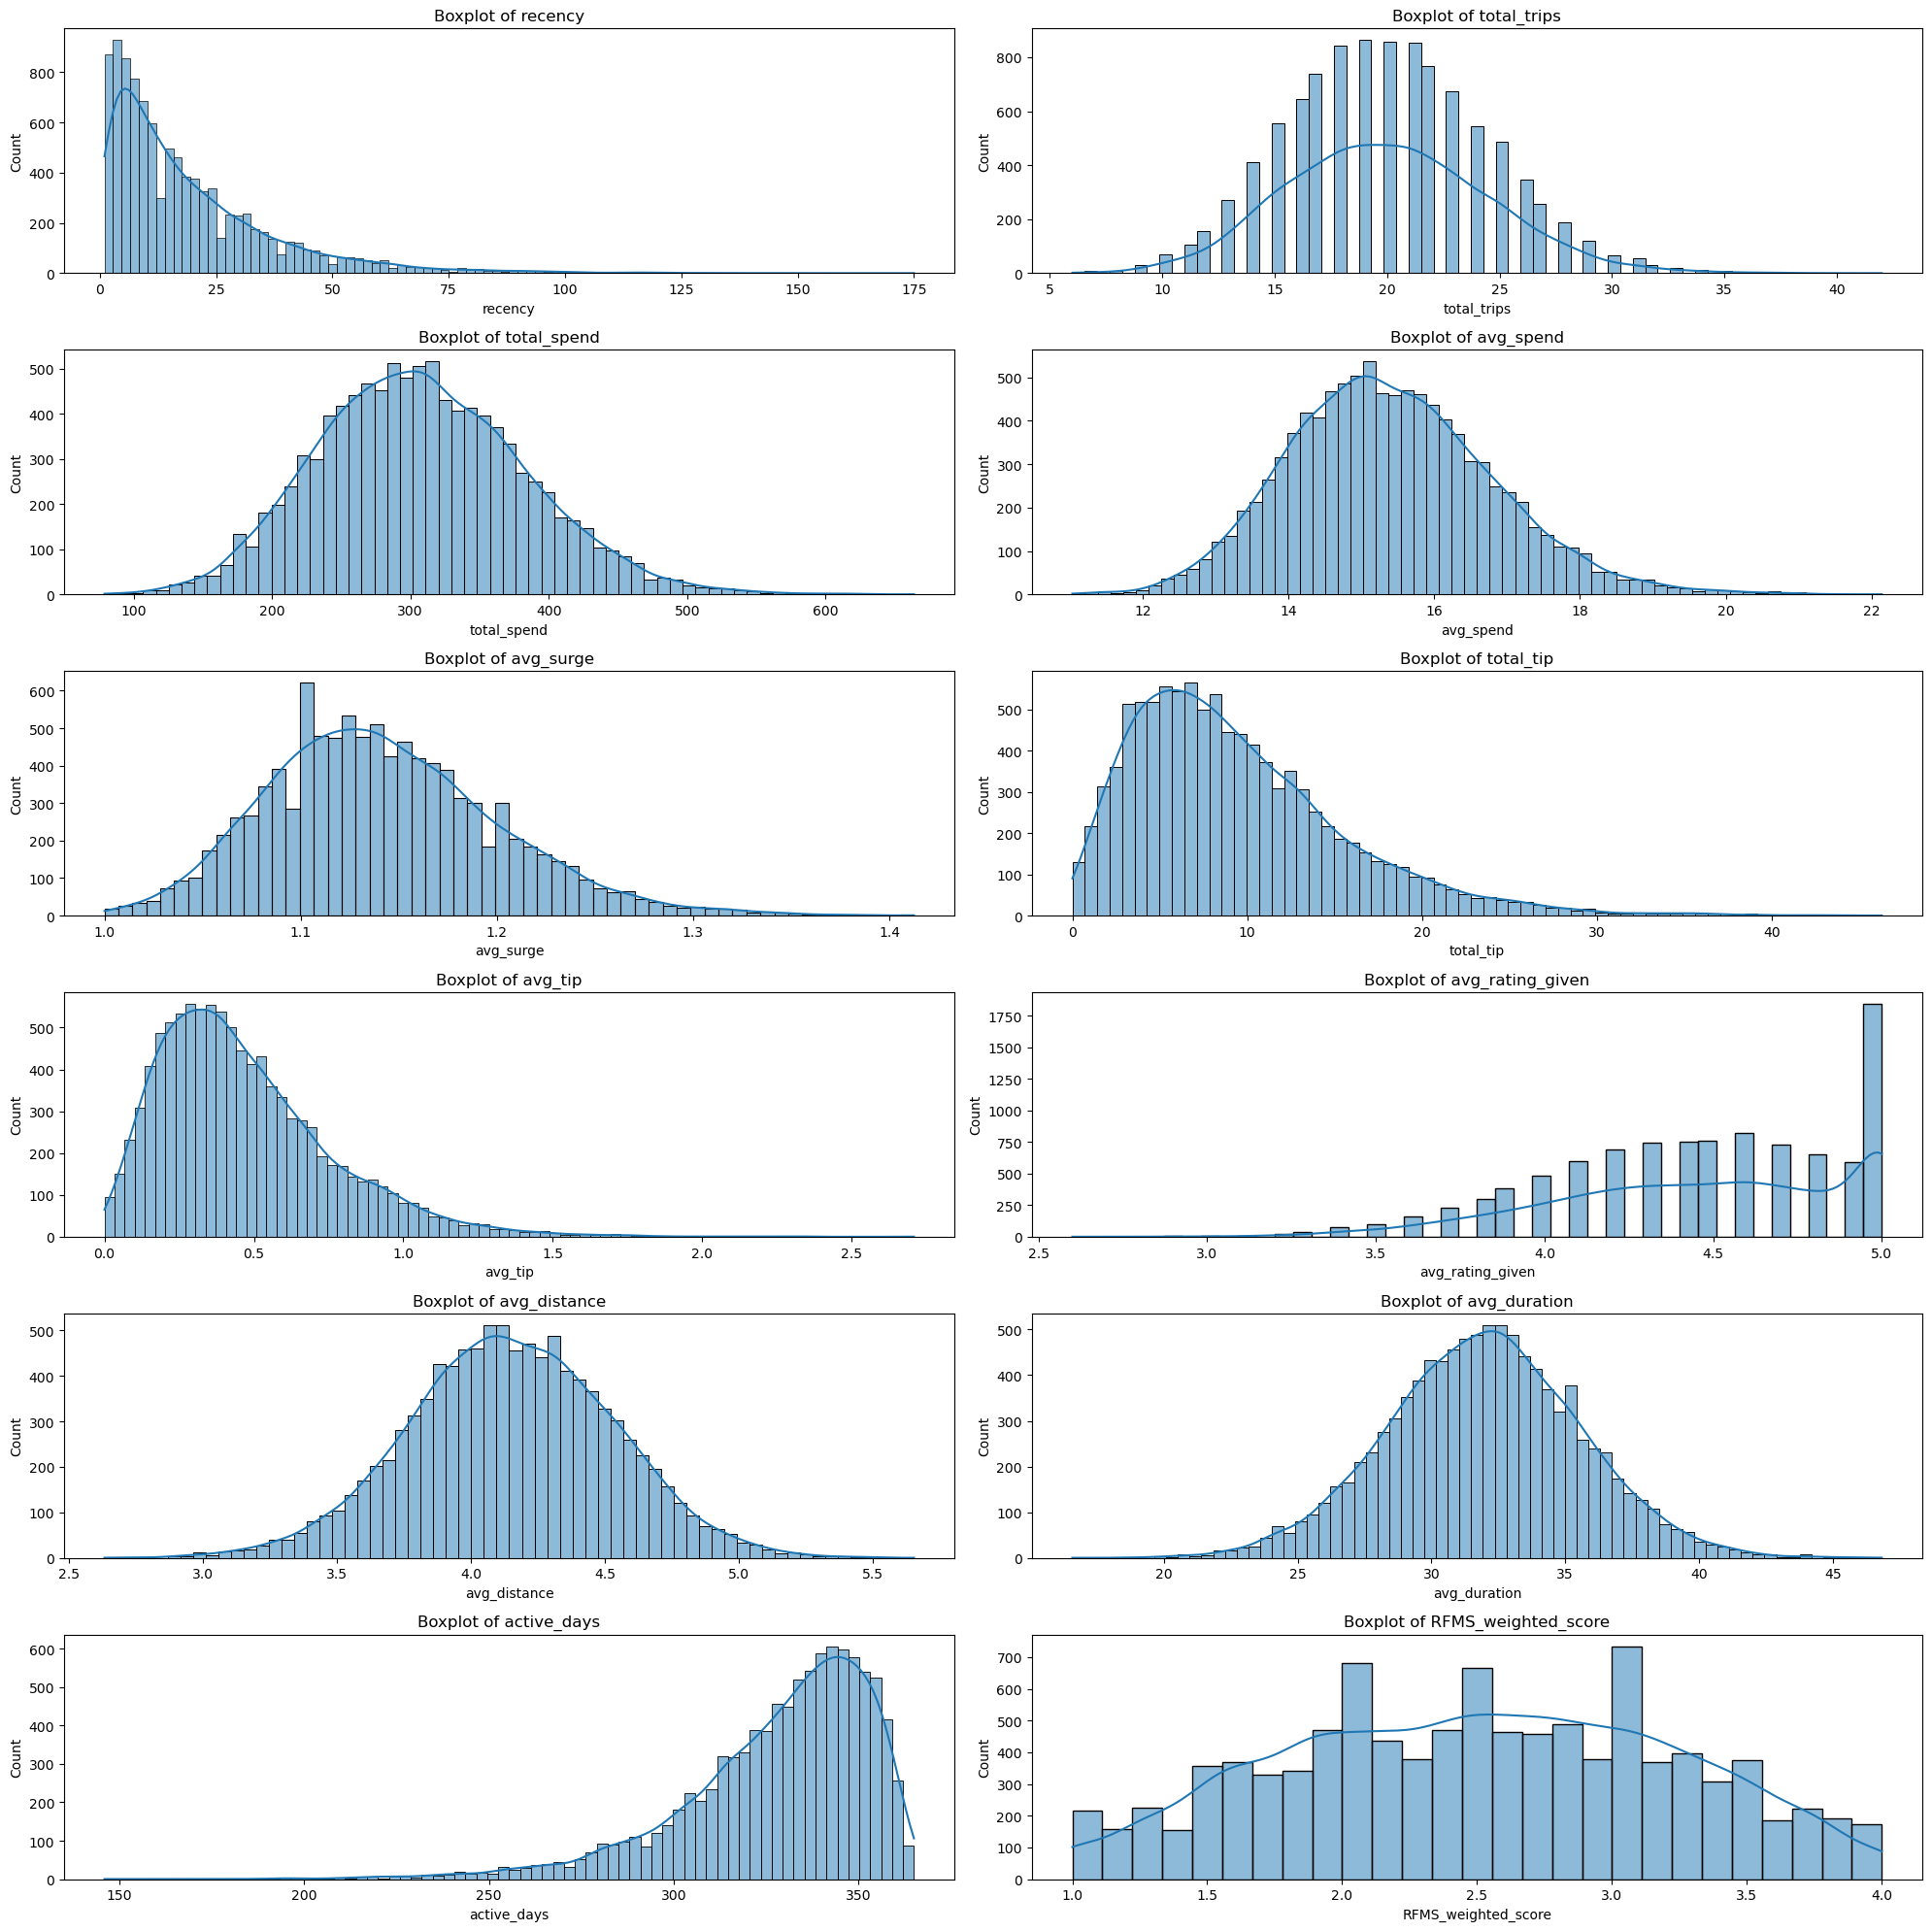

In [3]:
num_cols = df.select_dtypes(include='number')

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20,20))
ax = ax.flatten()
for idx, column in enumerate(num_cols):
    if df[column].name != 'churned': 
        sns.histplot(df[column], ax=ax[idx], kde=True)
        ax[idx].set_title(f"Boxplot of {column}")
plt.tight_layout()
plt.show();

The shape of the distributions can be described as:
- **Skewed Ditributions**: recency, total_tips, avg_tip, avg_rating_given, active_days. All skewed distributions have long tails indicating the presence of extreme values (Outliers).

- **Uniform Distributions**: total_trips, total_spend, avg_spend, avg_surge, avg_distance, avg_distance, RFMS_weighted_score.

#### Exploration of Outliers

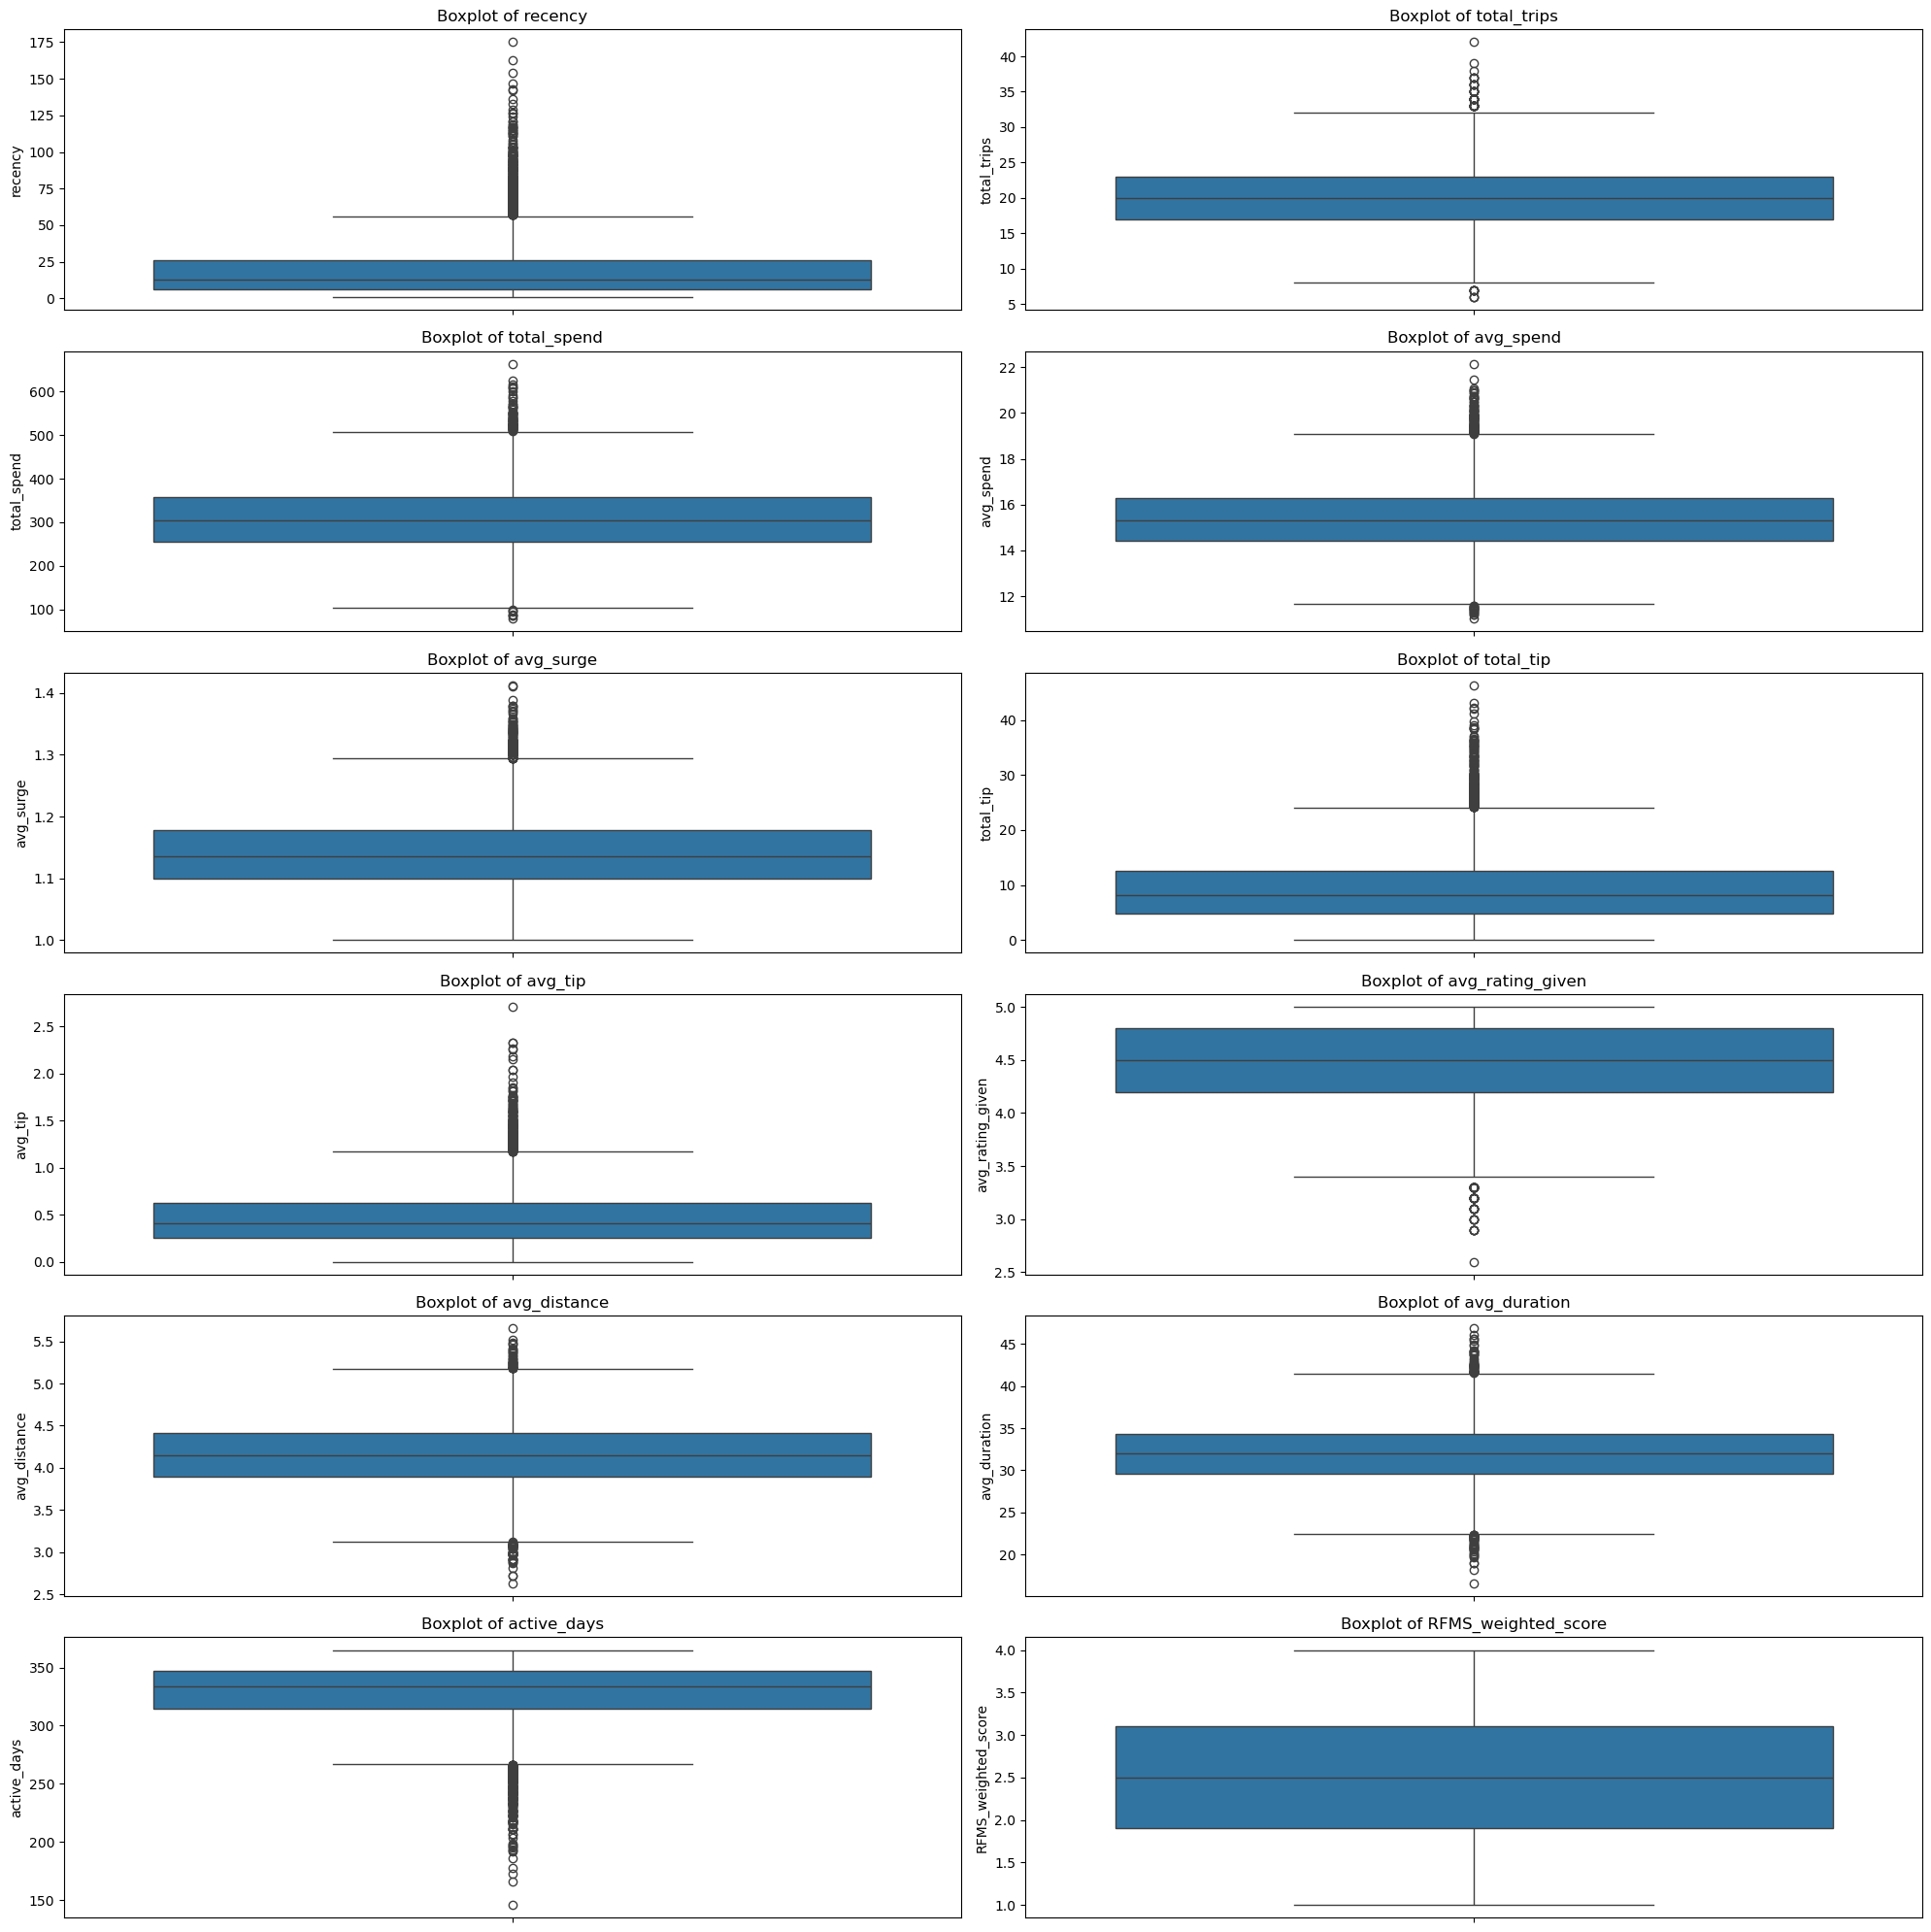

In [4]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20,20))
ax = ax.flatten()
for idx, column in enumerate(num_cols):
    if df[column].name != 'churned': 
        sns.boxplot(df[column], ax=ax[idx])
        ax[idx].set_title(f"Boxplot of {column}")
plt.tight_layout()
plt.show();

#### Checking for Multicolinearity

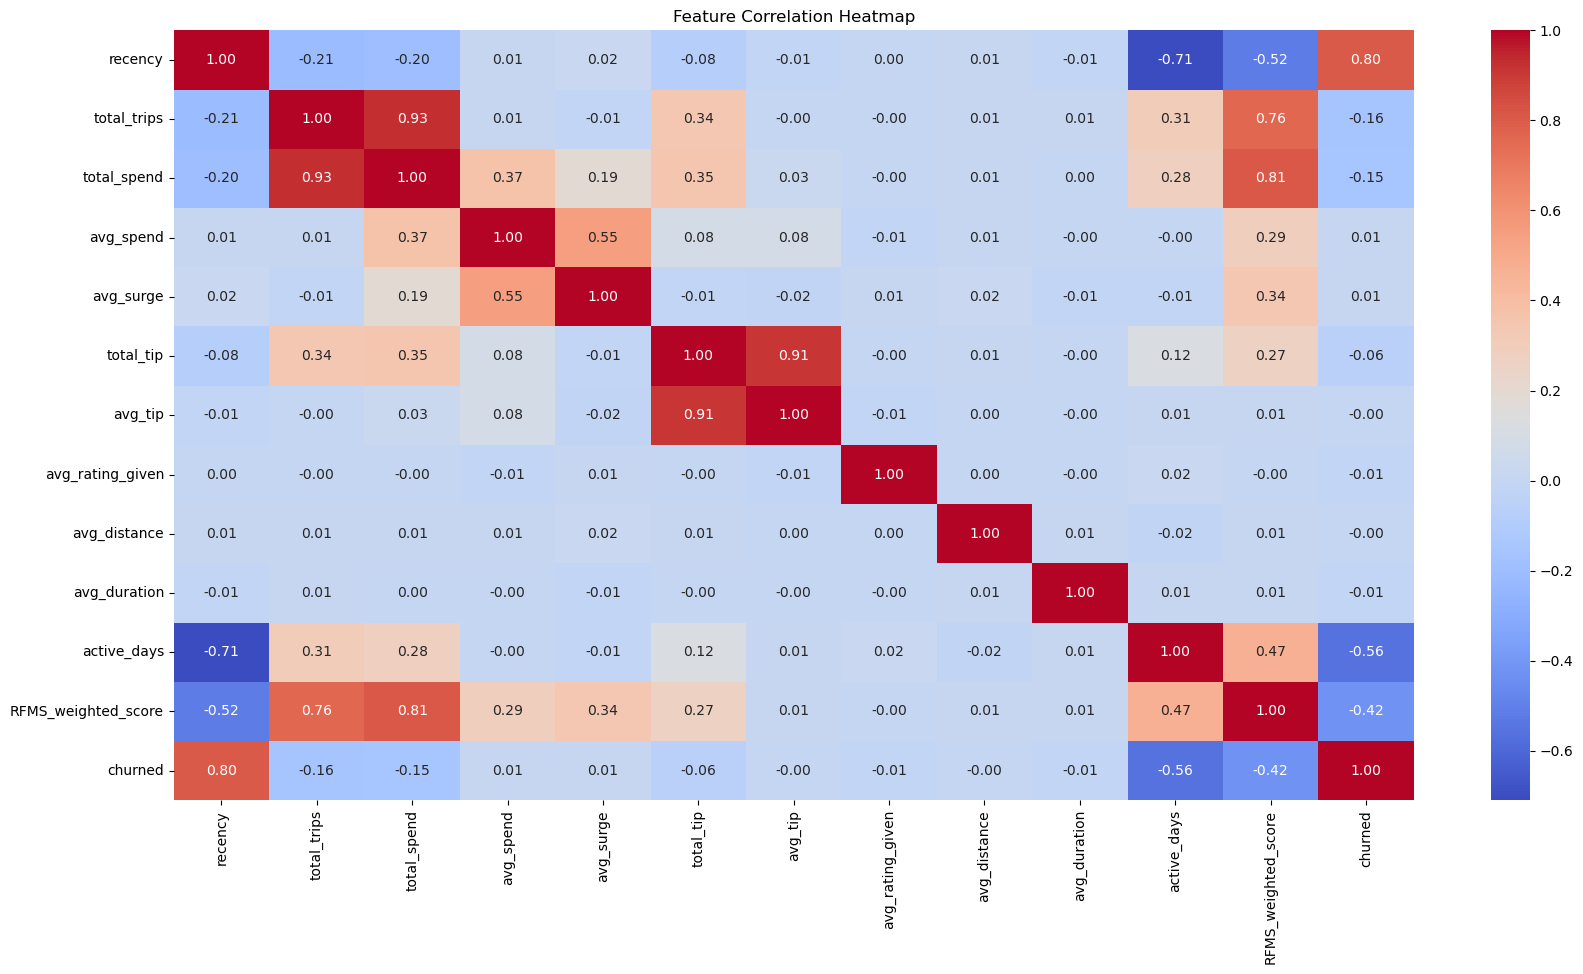

In [5]:
num_cols_corr = num_cols.corr().round(2)
plt.figure(figsize=(20,10))
sns.heatmap(num_cols_corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

### Dropping highly correlated features

In [6]:
encoded_df = df.copy()
encoded_df.drop(columns=['active_days', 'RFMS_weighted_score', 'total_spend', 'avg_surge'], inplace=True)
encoded_df.columns

Index(['user_id', 'recency', 'total_trips', 'avg_spend', 'total_tip',
       'avg_tip', 'avg_rating_given', 'loyalty_status', 'city', 'avg_distance',
       'avg_duration', 'RFMS_segment', 'churned'],
      dtype='object')

### Scaling Numerical Features

In [7]:
# scaler = RobustScaler()
# num_cols = encoded_df.select_dtypes(include='number').columns.tolist()

# encoded_df[num_cols] = scaler.fit_transform(encoded_df[num_cols])

In [8]:
# encoded_df = pd.get_dummies(encoded_df, columns=['city'])

### Encoding Categorical Columns

In [9]:
# encoded_df['RFMS_segment'].unique()

In [10]:
# loyalty_status_order = {
#     'Bronze': 0, 
#     'Silver': 1, 
#     'Gold': 2, 
#     'Platinum': 3
# }

# RFM_segments_order = {
#     'At Risk': 0, 
#     'Occasional Riders': 1, 
#     'Core Loyal Riders': 2, 
#     'High-Value Surge-Tolerant': 3
# }

# encoded_df['loyalty_status'] = encoded_df['loyalty_status'].map(loyalty_status_order)
# encoded_df['RFMS_segment'] = encoded_df['RFMS_segment'].map(RFM_segments_order)
# encoded_df.to_csv('../../data/processed_data/data_preprocessed.csv', index=False) 
# encoded_df

#### Define preprocessing pipelines

In [11]:
X = encoded_df.drop(columns=['churned', 'user_id'])
y = encoded_df['churned']

In [12]:
numeric_features = X.select_dtypes(include='number').columns.tolist()
nominal_categorical_features = ['city']
ordinal_categorical_features = ['loyalty_status', 'RFMS_segment']

ordinal_categories = [
    ['Bronze', 'Silver', 'Gold', 'Platinum'],  # loyalty_status
    ['At Risk', 'Occasional Riders', 'Core Loyal Riders', 'High-Value Surge-Tolerant']  # RFMS_segment
]

#### Scaling not needed for RF models
# Numeric preprocessing
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])

# Categorical preprocessing
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


ordinal_transformer = Pipeline(steps=[
    ("ordinal_encoder", OrdinalEncoder(categories=ordinal_categories, handle_unknown="use_encoded_value", unknown_value=-1))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("ord", ordinal_transformer, ordinal_categorical_features),
        ("cat", categorical_transformer, nominal_categorical_features)
    ],
    verbose_feature_names_out=False
)

X = preprocessor.fit_transform(X)

# Retrieve the new column names
column_names = preprocessor.get_feature_names_out()

# Reconstruct the DataFrame
X = pd.DataFrame(X, columns=column_names)

X

,recency,total_trips,avg_spend,total_tip,avg_tip,avg_rating_given,avg_distance,avg_duration,loyalty_status,RFMS_segment,city_Cairo,city_Lagos,city_Nairobi
0,0.65,0.833333,-0.354090,-0.540962,-0.685976,0.833333,-0.387163,-0.350886,0.0,2.0,0.0,0.0,1.0
1,-0.35,-1.000000,-1.287468,-0.966190,-0.978305,0.333333,-0.171057,-0.701175,0.0,0.0,0.0,0.0,1.0
2,0.10,0.666667,0.259925,-0.387516,-0.533177,-0.500000,0.755979,-0.095728,0.0,3.0,0.0,1.0,0.0
3,2.45,-1.833333,-0.966013,-0.951886,-0.862425,0.666667,1.347988,0.116034,0.0,0.0,0.0,0.0,1.0
4,0.00,-0.666667,0.786519,0.154746,0.476214,-1.000000,1.036558,0.861551,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.55,-1.166667,0.172129,-0.646294,-0.449485,-0.166667,-0.166381,-0.128530,1.0,1.0,0.0,1.0,0.0
9996,-0.50,-0.833333,-0.814279,0.318596,0.812753,-0.666667,0.480065,-0.278481,1.0,0.0,1.0,0.0,0.0
9997,1.70,-0.333333,1.019411,-0.457737,-0.417352,0.333333,0.703903,-0.058017,0.0,1.0,0.0,1.0,0.0
9998,0.35,0.333333,0.129817,0.305592,0.183215,-1.166667,-1.180150,0.768987,0.0,2.0,1.0,0.0,0.0


In [13]:
### Save preprocessor

In [14]:
import os

# Define model directory
BASE_DIR = "../../"
os.makedirs(BASE_DIR + 'output/model', exist_ok=True)

# File paths
PREPROCESSOR_PATH = os.path.join(BASE_DIR + "output/model/preprocessor.joblib")

# Save the trained model
joblib.dump(preprocessor, PREPROCESSOR_PATH)

['../../output/model/preprocessor.joblib']

### Separating features and splitting data into train/test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Checking for Class Imbalance

In [16]:
y_train.value_counts(normalize=True)*100    # checking the class imbalance of the target variable

churned
0    80.2125
1    19.7875
Name: proportion, dtype: float64

### Building Baseline Model (Logistic Model)

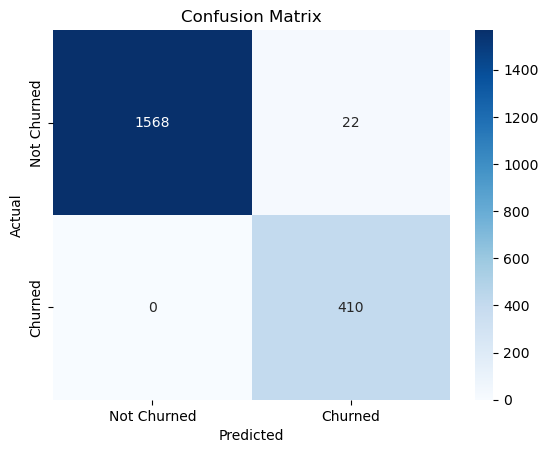

ROC-AUC: 1.0
The classification report of the model is: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1590
           1       0.95      1.00      0.97       410

    accuracy                           0.99      2000
   macro avg       0.97      0.99      0.98      2000
weighted avg       0.99      0.99      0.99      2000



In [17]:
# Model Training and Training 
lg = LogisticRegression(random_state=42, class_weight='balanced')
lg_model = lg.fit(X_train, y_train)

# Model Predictions
y_pred = lg_model.predict(X_test)
y_proba = lg_model.predict_proba(X_test)[:, 1]

# Metrics
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Plotting Confusion Matrix
sns.heatmap(matrix, annot= True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();

print("ROC-AUC:", round(roc_auc, 4))

print(f'The classification report of the model is: \n{report}')

## Model Evaluation Interpretation

### 🔹 ROC-AUC
- **ROC-AUC: 1.0**
- This indicates **excellent class separability**. The model is very effective at distinguishing between the two classes across all thresholds.

---

### 🔹 Overall Performance
- **Accuracy: 99%**
- The model performs very well overall, with only a very small number of misclassifications.

---

### 🔹 Class-wise Metrics

#### Class 0 (Negative Class)
- **Precision: 1.00**  
  → When the model predicts class 0, it is almost always correct.
- **Recall: 0.99**  
  → The model correctly identifies 99% of actual class 0 samples.
- **F1-score: 0.99**  
  → Excellent balance between precision and recall.
- **Support: 1590**  
  → Majority class.

#### Class 1 (Positive Class)
- **Precision: 0.95**  
  → About 11% of predicted positives are false positives.
- **Recall: 1.0**  
  → The model captures almost all actual positives (very low false negatives).
- **F1-score: 0.97**  
  → Strong performance, slightly affected by lower precision.
- **Support: 410**  
  → Minority class.

#### Exploring Feature Importance 

In [18]:
model_coeff = lg_model.coef_.ravel()

coefficients = pd.DataFrame({'Feature':X.columns,'Coefficient': model_coeff})
coefficients_sorted = coefficients.sort_values(by='Coefficient', ascending=False)
coefficients_sorted

,Feature,Coefficient
0,recency,15.309252
1,total_trips,0.345531
3,total_tip,0.226846
10,city_Cairo,0.079203
2,avg_spend,0.074790
7,avg_duration,-0.012249
5,avg_rating_given,-0.018087
11,city_Lagos,-0.019452
6,avg_distance,-0.052900
12,city_Nairobi,-0.059770




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



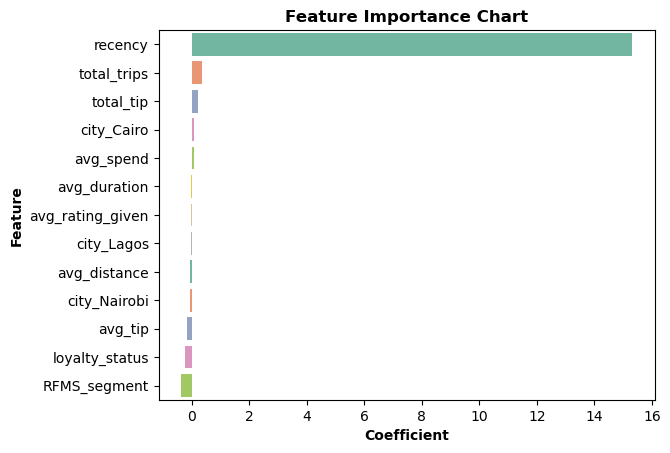

In [19]:
sns.barplot(x='Coefficient', y='Feature', data=coefficients_sorted, palette='Set2')
plt.title('Feature Importance Chart', weight='bold', fontsize='12')
plt.xlabel('Coefficient', weight='bold')
plt.ylabel('Feature', weight='bold')
plt.show();

#### Visualize Precision–Recall tradeoff

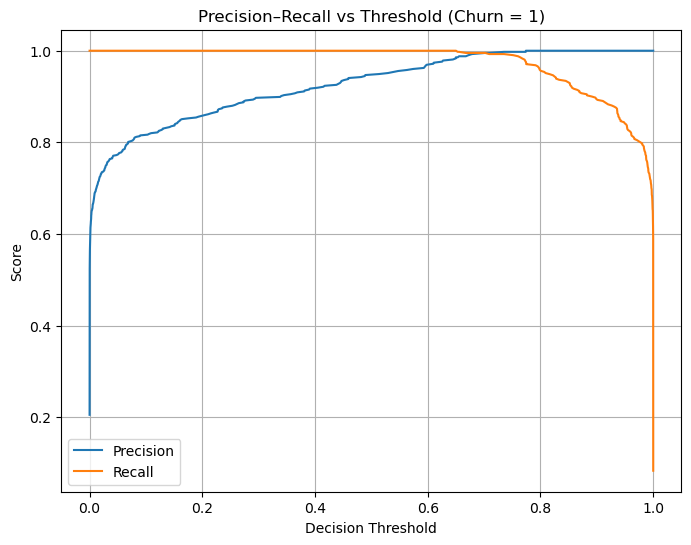

In [20]:


precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall vs Threshold (Churn = 1)")
plt.legend()
plt.grid(True)
plt.show()

### Building Advanced Classification Models (Decision Trees, Random Forest, SVM, KNN, Naive Bayes, XGBoost, and AdaBoost)

In [21]:
# !pip install XGBoost

In [22]:
models = {
    'RF_Classifier': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'GB_Classifier': GradientBoostingClassifier(random_state=42),
    'AdaBoost_Classifier': AdaBoostClassifier(random_state=42),
    'Dt_Classifier': DecisionTreeClassifier(random_state=42,),
    # 'SVM_Classifier': SVC(random_state=42, class_weight='balanced'),
    'KNN_Classifier': KNeighborsClassifier(),
    'NB_Classifier': GaussianNB()
    }

### Training and Evaluating the advanced models

 

Training the RF_Classifier model
The accuracy of the RF_Classifier model is: 1.0
The confusion matrix of the RF_Classifier model is: 
[[1590    0]
 [   0  410]]
The classification report of the RF_Classifier model is: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1590
           1       1.00      1.00      1.00       410

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



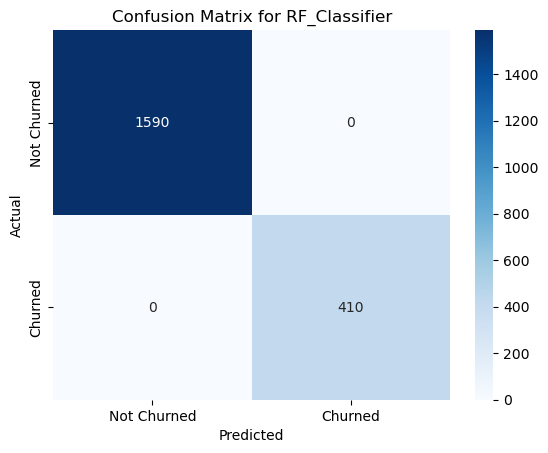

 

Training the GB_Classifier model
The accuracy of the GB_Classifier model is: 1.0
The confusion matrix of the GB_Classifier model is: 
[[1590    0]
 [   0  410]]
The classification report of the GB_Classifier model is: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1590
           1       1.00      1.00      1.00       410

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



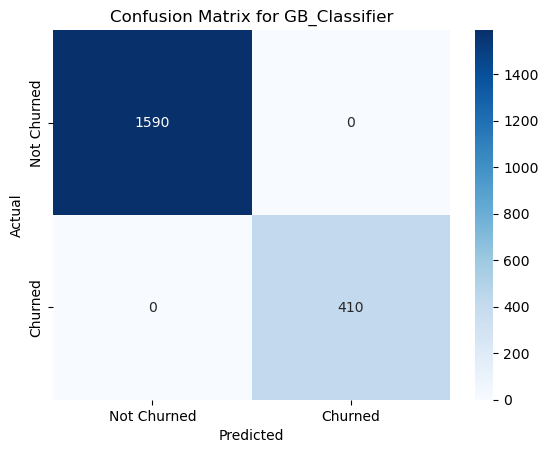

 

Training the AdaBoost_Classifier model
The accuracy of the AdaBoost_Classifier model is: 1.0
The confusion matrix of the AdaBoost_Classifier model is: 
[[1590    0]
 [   0  410]]
The classification report of the AdaBoost_Classifier model is: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1590
           1       1.00      1.00      1.00       410

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



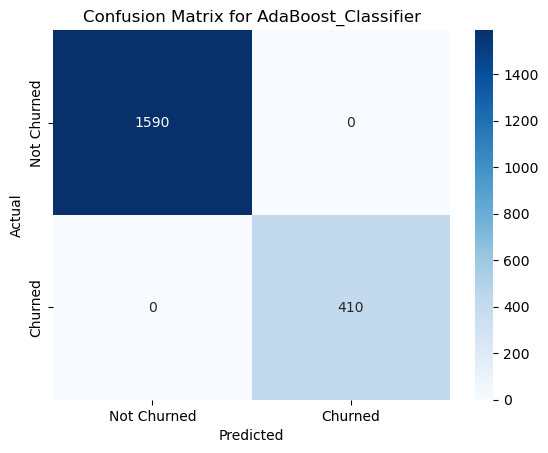

 

Training the Dt_Classifier model
The accuracy of the Dt_Classifier model is: 1.0
The confusion matrix of the Dt_Classifier model is: 
[[1590    0]
 [   0  410]]
The classification report of the Dt_Classifier model is: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1590
           1       1.00      1.00      1.00       410

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



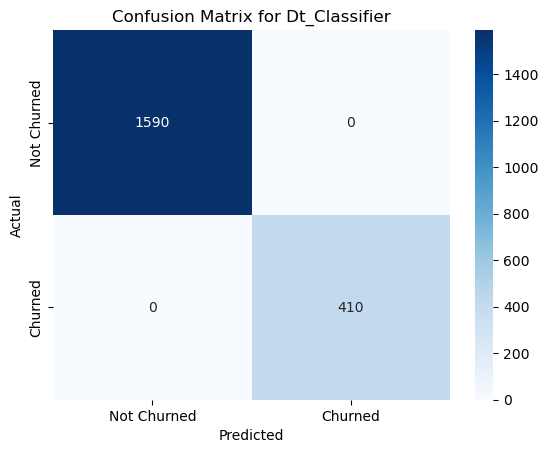

 

Training the KNN_Classifier model
The accuracy of the KNN_Classifier model is: 0.9445
The confusion matrix of the KNN_Classifier model is: 
[[1572   18]
 [  93  317]]
The classification report of the KNN_Classifier model is: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1590
           1       0.95      0.77      0.85       410

    accuracy                           0.94      2000
   macro avg       0.95      0.88      0.91      2000
weighted avg       0.94      0.94      0.94      2000



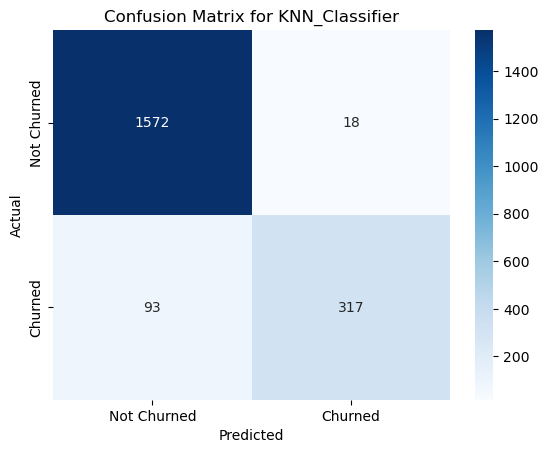

 

Training the NB_Classifier model
The accuracy of the NB_Classifier model is: 0.953
The confusion matrix of the NB_Classifier model is: 
[[1528   62]
 [  32  378]]
The classification report of the NB_Classifier model is: 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1590
           1       0.86      0.92      0.89       410

    accuracy                           0.95      2000
   macro avg       0.92      0.94      0.93      2000
weighted avg       0.95      0.95      0.95      2000



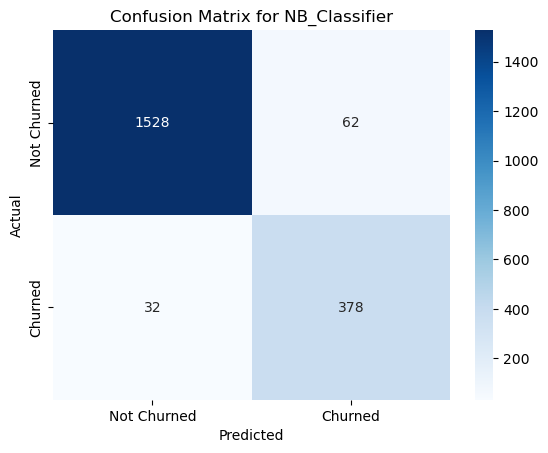

In [23]:
for model_name, model in models.items():
  print(' \n')
  print(f'Training the {model_name} model')
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f'The accuracy of the {model_name} model is: {accuracy}')
    
  report = classification_report(y_test, y_pred)
  matrix = confusion_matrix(y_test, y_pred)
    
  sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
  plt.title(f'Confusion Matrix for {model_name}')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  print(f'The confusion matrix of the {model_name} model is: \n{matrix}')
  print(f'The classification report of the {model_name} model is: \n{report}')
  plt.show();

### Give justification why Random Forest was choosen. 

#### Create a threshold performance table

In [24]:
threshold_grid = np.arange(0.05, 0.95, 0.05)

rows = []

for t in threshold_grid:
    y_pred_t = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    
    rows.append({
        "threshold": t,
        "precision": tp / (tp + fp) if (tp + fp) > 0 else 0,
        "recall": tp / (tp + fn) if (tp + fn) > 0 else 0,
        "false_positives": fp,
        "false_negatives": fn
    })

threshold_df = pd.DataFrame(rows)
display(threshold_df)

,threshold,precision,recall,false_positives,false_negatives
0,0.05,0.773585,1.000000,120,0
1,0.10,0.816733,1.000000,92,0
2,0.15,0.836735,1.000000,80,0
3,0.20,0.859539,1.000000,67,0
4,0.25,0.879828,1.000000,56,0
5,0.30,0.899123,1.000000,46,0
6,0.35,0.905077,1.000000,43,0
7,0.40,0.919283,1.000000,36,0
8,0.45,0.936073,1.000000,28,0
9,0.50,0.949074,1.000000,22,0


#### Create a threshold performance table

In [25]:
BUSINESS_THRESHOLD = 0.35

y_pred_business = (y_proba >= BUSINESS_THRESHOLD).astype(int)

print("Chosen threshold:", BUSINESS_THRESHOLD)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_business))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_business))

Chosen threshold: 0.35

Confusion Matrix:
[[1547   43]
 [   0  410]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1590
           1       0.91      1.00      0.95       410

    accuracy                           0.98      2000
   macro avg       0.95      0.99      0.97      2000
weighted avg       0.98      0.98      0.98      2000



#### Visualize confusion matrix

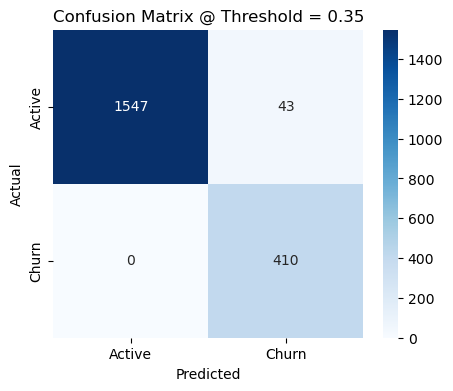

In [26]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_business)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Active", "Churn"],
            yticklabels=["Active", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix @ Threshold = {BUSINESS_THRESHOLD}")
plt.show()

### Computing and plotting the Random Forest Classifier feature importance

In [27]:
importances = models['RF_Classifier'].feature_importances_      # Getting feature importances from Random Forest

# Putting them into a DataFrame
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)

feature_importances_sorted

,Feature,Importance
0,recency,0.844878
9,RFMS_segment,0.098450
1,total_trips,0.019548
2,avg_spend,0.008585
3,total_tip,0.006719
7,avg_duration,0.005595
4,avg_tip,0.005439
6,avg_distance,0.005390
5,avg_rating_given,0.002899
8,loyalty_status,0.001160




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



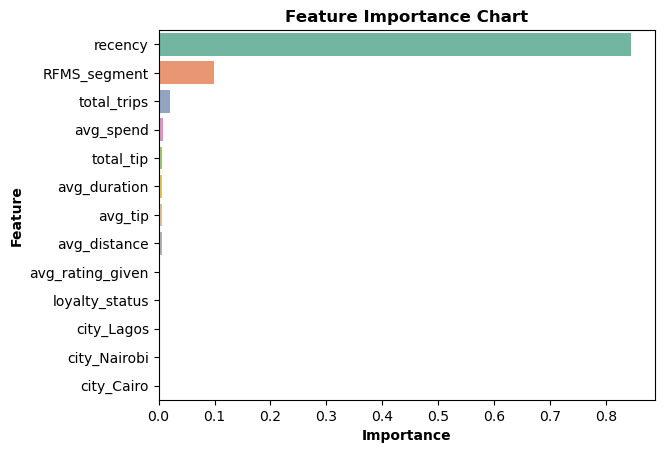

In [28]:
sns.barplot(x='Importance', y='Feature', data=feature_importances_sorted, palette='Set2')
plt.title('Feature Importance Chart', weight='bold', fontsize='12')
plt.xlabel('Importance', weight='bold')
plt.ylabel('Feature', weight='bold')
plt.show();

**ROC Curve and AUC Score**

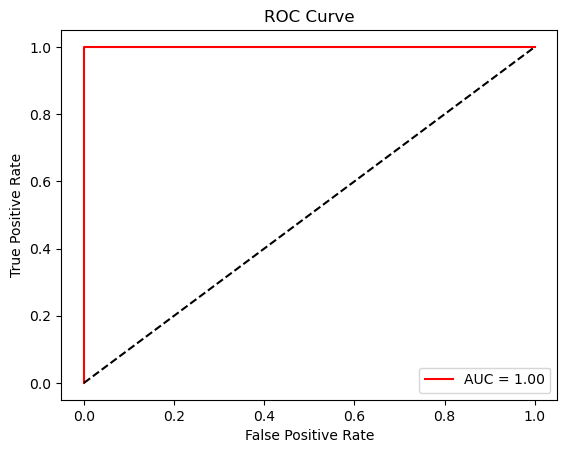

In [29]:
y_probability = models['RF_Classifier'].predict_proba(X_test)[:,1]

fpr, tpr, tresholds = roc_curve(y_test, y_probability)
auc_score = roc_auc_score(y_test, y_probability)

plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='red')
plt.plot([0,1],[0,1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show();

### Saving the Model

In [30]:
# Define model directory
BASE_DIR = Path.cwd().parents[1]

MODEL_DIR = BASE_DIR / "output" / "model"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# File paths
MODEL_PATH = MODEL_DIR / "rfm_churn_model.joblib"
METADATA_PATH = MODEL_DIR / "rfm_churn_model_metadata.joblib"

# Save the trained model
joblib.dump(models['RF_Classifier'], MODEL_PATH)

# Save metadata needed for inference
joblib.dump(
    {
        "business_threshold": BUSINESS_THRESHOLD,
        "feature_columns": X.columns.tolist()
    },
    METADATA_PATH
)

print("✅ Model saved to:", MODEL_PATH)
print("✅ Metadata saved to:", METADATA_PATH)

✅ Model saved to: C:\Users\godfr\Documents\Amdari\Project 4 - Final\output\model\rfm_churn_model.joblib
✅ Metadata saved to: C:\Users\godfr\Documents\Amdari\Project 4 - Final\output\model\rfm_churn_model_metadata.joblib


### Promotion Strategy Mapping

In [31]:
df_results = df.loc[X_test.index].copy()
df_results["churn_probability"] = y_proba
df_results["churn_risk"] = pd.cut(
    df_results["churn_probability"],
    bins=[0, 0.35, 0.65, 1.0],
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

df_results["RFMS_segment"].value_counts()

RFMS_segment
Core Loyal Riders            515
High-Value Surge-Tolerant    505
At Risk                      502
Occasional Riders            478
Name: count, dtype: int64

#### Churn Risk × RFMS Segment matrix

In [32]:
segment_matrix = (
    df_results
    .groupby(["RFMS_segment", "churn_risk"], observed=False)
    .size()
    .unstack(fill_value=0)
)

display(segment_matrix)

churn_risk,Low Risk,Medium Risk,High Risk
RFMS_segment,,,
At Risk,258,19,225
Core Loyal Riders,418,13,84
High-Value Surge-Tolerant,505,0,0
Occasional Riders,366,6,106


#### Heatmap of risk by segment

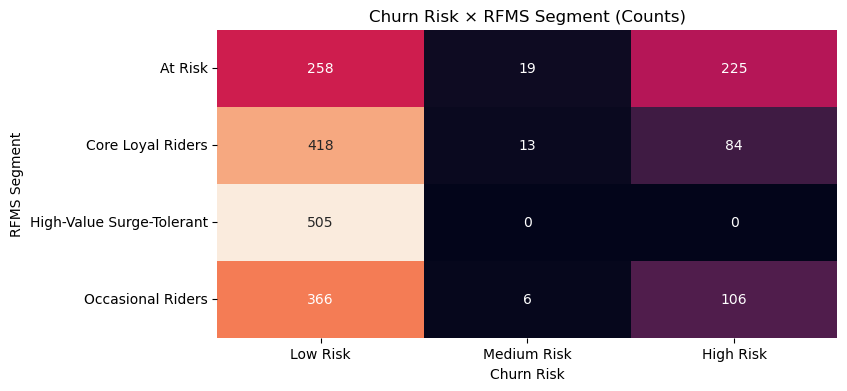

In [33]:
plt.figure(figsize=(8, 4))
sns.heatmap(segment_matrix, annot=True, fmt="d", cbar=False)
plt.title("Churn Risk × RFMS Segment (Counts)")
plt.xlabel("Churn Risk")
plt.ylabel("RFMS Segment")
plt.show()

#### Convert to row percentages (better for comparison)

In [34]:
segment_matrix_pct = (segment_matrix.div(segment_matrix.sum(axis=1), axis=0) * 100).round(1)
display(segment_matrix_pct)

churn_risk,Low Risk,Medium Risk,High Risk
RFMS_segment,,,
At Risk,51.4,3.8,44.8
Core Loyal Riders,81.2,2.5,16.3
High-Value Surge-Tolerant,100.0,0.0,0.0
Occasional Riders,76.6,1.3,22.2


#### Heatmap of percentages

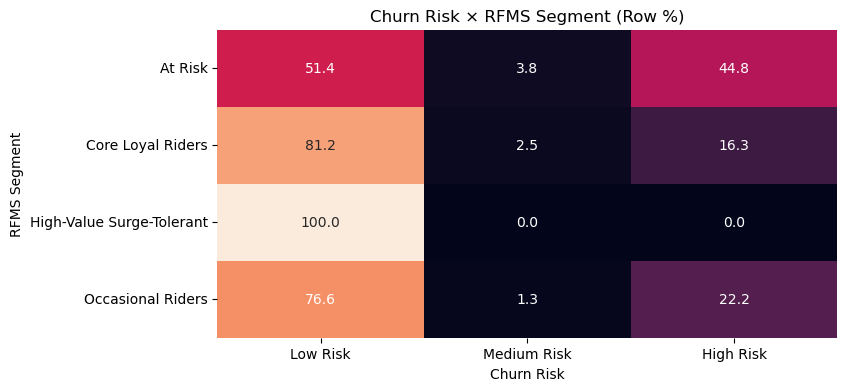

In [35]:
plt.figure(figsize=(8, 4))
sns.heatmap(segment_matrix_pct, annot=True, fmt=".1f", cbar=False)
plt.title("Churn Risk × RFMS Segment (Row %)")
plt.xlabel("Churn Risk")
plt.ylabel("RFMS Segment")
plt.show()

#### Turn this into a Promotion

#### Define actions per (Segment × Risk)

In [36]:
playbook = {
    ("High-Value Surge-Tolerant", "Low Risk"): "Reward/recognition (no discounts): loyalty perks, priority support, surprise upgrades",
    ("High-Value Surge-Tolerant", "Medium Risk"): "Investigate anomalies; VIP outreach; check service issues",
    ("High-Value Surge-Tolerant", "High Risk"): "Immediate VIP retention: personalized offer + support intervention",

    ("Core Loyal Riders", "Low Risk"): "Maintain loyalty: points boosts, referrals, cross-sell (subscriptions/bundles)",
    ("Core Loyal Riders", "Medium Risk"): "Nudge: personalized reminders, small incentive tied to off-peak usage",
    ("Core Loyal Riders", "High Risk"): "Win-back: targeted credit + service recovery; ask for feedback",

    ("Occasional Riders", "Low Risk"): "Engagement nudges: new-feature prompts, seasonal campaigns, gentle reminders",
    ("Occasional Riders", "Medium Risk"): "Activation: first-ride-after-gap offer, time-limited promo",
    ("Occasional Riders", "High Risk"): "Reactivation: stronger discount + convenience messaging + off-peak targeting",

    ("At Risk", "Low Risk"): "Monitor: low-cost reminders + reduce friction (payment, app UX)",
    ("At Risk", "Medium Risk"): "Targeted off-peak discount + onboarding education (how to save/avoid surge)",
    ("At Risk", "High Risk"): "Highest priority: churn-prevention package (discount + surge relief + reactivation messaging)",
}

df_results["recommended_action"] = df_results.apply(
    lambda r: playbook.get((r["RFMS_segment"], r["churn_risk"]), "No rule defined"),
    axis=1
)

df_results[["user_id", "RFMS_segment", "churn_probability", "churn_risk", "recommended_action"]].head(10)

,user_id,RFMS_segment,churn_probability,churn_risk,recommended_action
6252,R06252,High-Value Surge-Tolerant,7.541993e-10,Low Risk,Reward/recognition (no discounts): loyalty per...
4684,R04684,High-Value Surge-Tolerant,7.445389e-10,Low Risk,Reward/recognition (no discounts): loyalty per...
1731,R01731,Core Loyal Riders,2.411461e-06,Low Risk,"Maintain loyalty: points boosts, referrals, cr..."
4742,R04742,Occasional Riders,1.322761e-09,Low Risk,"Engagement nudges: new-feature prompts, season..."
4521,R04521,Core Loyal Riders,6.305263e-02,Low Risk,"Maintain loyalty: points boosts, referrals, cr..."
6340,R06340,Core Loyal Riders,3.587836e-03,Low Risk,"Maintain loyalty: points boosts, referrals, cr..."
576,R00576,Occasional Riders,2.908943e-02,Low Risk,"Engagement nudges: new-feature prompts, season..."
5202,R05202,Occasional Riders,1.509643e-08,Low Risk,"Engagement nudges: new-feature prompts, season..."
6363,R06363,Core Loyal Riders,1.149842e-07,Low Risk,"Maintain loyalty: points boosts, referrals, cr..."
439,R00439,Core Loyal Riders,1.461684e-06,Low Risk,"Maintain loyalty: points boosts, referrals, cr..."


#### Summary: how many users per recommended action

In [37]:
action_summary = df_results["recommended_action"].value_counts().to_frame("count")
display(action_summary)

,count
recommended_action,
"Reward/recognition (no discounts): loyalty perks, priority support, surprise upgrades",505
"Maintain loyalty: points boosts, referrals, cross-sell (subscriptions/bundles)",418
"Engagement nudges: new-feature prompts, seasonal campaigns, gentle reminders",366
"Monitor: low-cost reminders + reduce friction (payment, app UX)",258
Highest priority: churn-prevention package (discount + surge relief + reactivation messaging),225
Reactivation: stronger discount + convenience messaging + off-peak targeting,106
Win-back: targeted credit + service recovery; ask for feedback,84
Targeted off-peak discount + onboarding education (how to save/avoid surge),19
"Nudge: personalized reminders, small incentive tied to off-peak usage",13


In [38]:
### Testing

In [39]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['recency', 'total_trips', 'avg_spend',
                                  'total_tip', 'avg_tip', 'avg_rating_given',
                                  'avg_distance', 'avg_duration']),
                                ('ord',
                                 Pipeline(steps=[('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['Bronze',
                                                                              'Silver',
                                                                              'Gold',
                                                                              'Platinum'],
                                                                             ['At '
                                                                              'Risk',
                                                                              'Occasional '
                                                                              'Riders',
                                                                              'Core '
                                                                              'Loyal '
                                                                              'Riders',
                                                                              'High-Value '
                                                                              'Surge-Tolerant']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['loyalty_status', 'RFMS_segment']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['city'])],
                  verbose_feature_names_out=False)

In [40]:
# # Define model directory
BASE_DIR = Path.cwd().parents[1]

MODEL_DIR = BASE_DIR / "output" / "model"
# MODEL_DIR.mkdir(parents=True, exist_ok=True)

# # File paths
MODEL_PATH = MODEL_DIR / "rfm_churn_model.joblib"
METADATA_PATH = MODEL_DIR / "rfm_churn_model_metadata.joblib"

# load the trained model
rf_model = joblib.load(MODEL_PATH)

# Save metadata needed for inference
metadata = joblib.load(METADATA_PATH)

print(rf_model)
print('\n')
print(metadata)
# rf_model = models['RF_Classifier']

RandomForestClassifier(class_weight='balanced', random_state=42)


{'business_threshold': 0.35, 'feature_columns': ['recency', 'total_trips', 'avg_spend', 'total_tip', 'avg_tip', 'avg_rating_given', 'avg_distance', 'avg_duration', 'loyalty_status', 'RFMS_segment', 'city_Cairo', 'city_Lagos', 'city_Nairobi']}


In [41]:
data = { 
    'recency': 30.0, 
    'total_trips': 20.0, 
    'avg_spend': 15.0, 
    'total_tip': 3.0, 
    'avg_tip': 0.15, 
    'avg_rating_given': 4.0, 
    'avg_distance': 5.0,
    'avg_duration': 18.0, 
    'loyalty_status': 'Bronze', 
    'RFMS_segment': 'At Risk', 
    'city': 'Cairo'
}

test = pd.DataFrame([data])
test

,recency,total_trips,avg_spend,total_tip,avg_tip,avg_rating_given,avg_distance,avg_duration,loyalty_status,RFMS_segment,city
0,30.0,20.0,15.0,3.0,0.15,4.0,5.0,18.0,Bronze,At Risk,Cairo


In [42]:
transformed_data = preprocessor.transform(test)

# Retrieve the new column names
column_names = preprocessor.get_feature_names_out()

# Reconstruct the DataFrame
transformed_data = pd.DataFrame(transformed_data, columns=column_names)

transformed_data

,recency,total_trips,avg_spend,total_tip,avg_tip,avg_rating_given,avg_distance,avg_duration,loyalty_status,RFMS_segment,city_Cairo,city_Lagos,city_Nairobi
0,0.85,0.0,-0.16282,-0.674902,-0.716599,-0.833333,1.664363,-2.924051,0.0,0.0,1.0,0.0,0.0


In [43]:
# Model Predictions
y_pred = rf_model.predict(transformed_data)
y_proba = rf_model.predict_proba(transformed_data)[:, 1]
print(y_pred)
print('\n')
print(y_proba)
print('\n')


threshold = metadata.get("business_threshold", 0.35)
pred = 1 if y_proba >= threshold else 0



churn_probability=round(float(y_proba), 4),
churn_prediction=int(pred),
business_threshold=float(threshold)


print(churn_probability)
print('\n')
print(churn_prediction)
print('\n')
print(business_threshold)

[0]


[0.04]


(0.04,)


(0,)


0.35


Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
